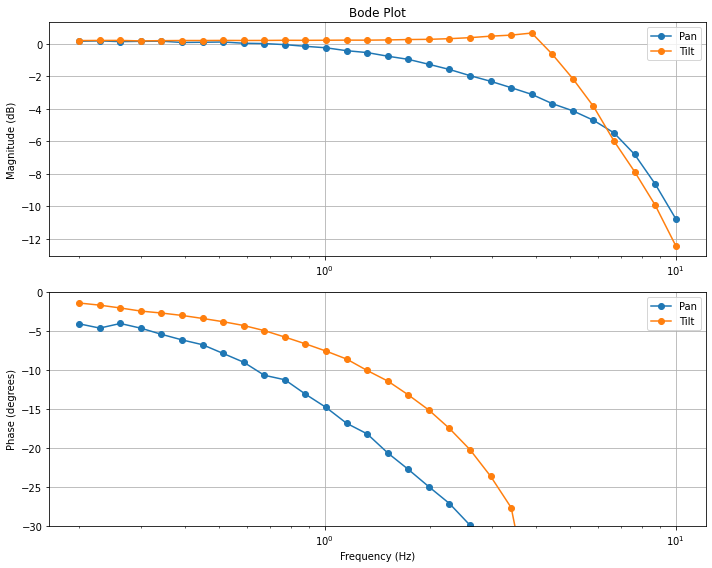

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import hann

def compute_response(frequency, time_data, input_data, output_data):
    """
    Compute the magnitude and phase response of the system at a specific frequency
    with windowing applied to reduce spectral leakage.
    """
    dt = np.mean(np.diff(time_data))
    window = hann(len(input_data))  # Apply a Hanning window

    # Apply window to both input and output data
    input_data_windowed = input_data * window
    output_data_windowed = output_data * window

    # Rest of the code remains the same...
    input_fft = fft(input_data_windowed)
    output_fft = fft(output_data_windowed)
    freqs = np.fft.fftfreq(len(input_data), dt)

    freq_idx = np.argmin(np.abs(freqs - frequency))
    input_mag = np.abs(input_fft[freq_idx])
    output_mag = np.abs(output_fft[freq_idx])
    magnitude_db = 20 * np.log10(output_mag / input_mag)

    input_phase = np.angle(input_fft[freq_idx])
    output_phase = np.angle(output_fft[freq_idx])
    phase_diff_deg = np.rad2deg(output_phase - input_phase)

    if phase_diff_deg > 180:
        phase_diff_deg += -360

    return magnitude_db, phase_diff_deg


def load_and_process_data(frequencies):
    """
    Load the data for each frequency and compute the magnitude and phase.

    Args:
        frequencies (np.ndarray): Frequencies at which the data was collected.

    Returns:
        tuple: pan_magnitudes and pan_phases for each frequency.
    """
    pan_magnitudes, pan_phases, tilt_magnitudes, tilt_phases = [], [], [], []
    
    for freq in frequencies:
        data_filename = f'data/data_{freq}Hz.npz'
        data = np.load(data_filename)
        time_list, theta_d_list, pan_pos_list, tilt_pos_list = [data[f] for f in data.files]

        pan_magnitude_db, pan_phase_diff_deg = compute_response(freq, time_list, theta_d_list, pan_pos_list)
        tilt_magnitude_db, tilt_phase_diff_deg = compute_response(freq, time_list, theta_d_list, tilt_pos_list)


        pan_magnitudes.append(pan_magnitude_db)
        pan_phases.append(pan_phase_diff_deg)
        tilt_magnitudes.append(tilt_magnitude_db)
        tilt_phases.append(tilt_phase_diff_deg)

    return np.array(pan_magnitudes), np.array(pan_phases), np.array(tilt_magnitudes), np.array(tilt_phases)

def plot_bode(frequencies, pan_magnitudes, pan_phases, tilt_magnitudes, tilt_phases):
    """
    Plot the Bode plot of magnitude and phase against frequencies.

    Args:
        frequencies (np.ndarray): Array of frequencies.
        pan_magnitudes (np.ndarray): Array of pan_magnitudes in dB.
        pan_phases (np.ndarray): Array of pan_phases in degrees.
    """
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.semilogx(frequencies, pan_magnitudes, '-o')
    plt.semilogx(frequencies, tilt_magnitudes, '-o')
    plt.grid(True)
    plt.title('Bode Plot')
    plt.ylabel('Magnitude (dB)')
    plt.legend(['Pan', 'Tilt'])
    
    plt.subplot(2, 1, 2)
    plt.semilogx(frequencies, pan_phases, '-o')
    plt.semilogx(frequencies, tilt_phases, '-o')
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.legend(['Pan', 'Tilt'])
    # Set y lim to -30
    plt.ylim(-30, 0)
    
    plt.tight_layout()
    plt.show()

frequencies = np.round(np.logspace(np.log10(0.2), np.log10(10), 30), 30)
pan_magnitudes, pan_phases, tilt_magnitudes, tilt_phases = load_and_process_data(frequencies)
plot_bode(frequencies, pan_magnitudes, pan_phases, tilt_magnitudes, tilt_phases)


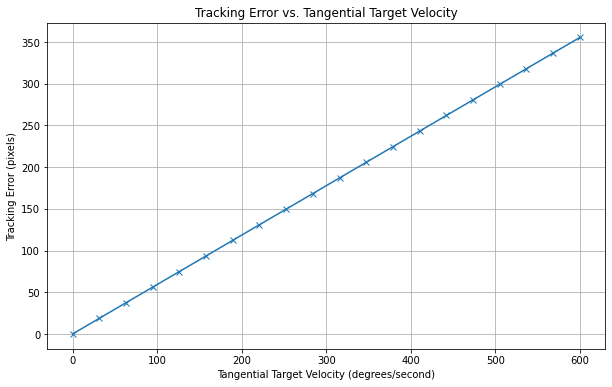

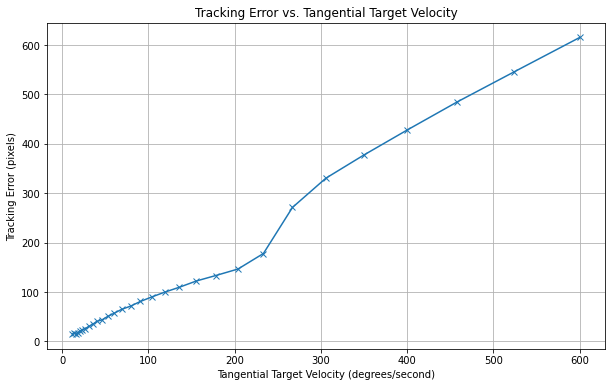

In [3]:
def calculate_spatial_error_for_velocity(velocity, phase_delay, fov_width, resolution_x):
    """
    Calculate the spatial error for a given target velocity.
    """
    # Assume a constant frequency or derive it from velocity if applicable
    frequency = 1.0  # Hz, example fixed frequency
    
    # Convert phase delay to time delay as before
    time_delay = phase_delay / 360 / frequency
    
    # Calculate spatial error in degrees assuming the motion speed equals the target velocity
    spatial_error_deg = velocity * time_delay
    
    # Convert spatial error to pixels
    error_pixels = spatial_error_deg * (resolution_x / fov_width)
    
    return error_pixels

def plot_error_against_velocity(velocities, phase_delay, fov_width, resolution_x):
    """
    Plot spatial tracking error as a function of tangential target velocity.
    """
    errors = [calculate_spatial_error_for_velocity(v, phase_delay, fov_width, resolution_x) for v in velocities]
    
    plt.figure(figsize=(10, 6))
    plt.plot(velocities, errors, '-x')
    plt.xlabel('Tangential Target Velocity (degrees/second)')
    plt.ylabel('Tracking Error (pixels)')
    plt.title('Tracking Error vs. Tangential Target Velocity')
    plt.grid(True)
    plt.show()

# Example parameters
phase_delay = 10  # degrees, example phase delay
fov_width = 90  # degrees
resolution_x = 1920  # pixels
velocities = np.linspace(0, 600, 20)  # Tangential target velocities in degrees/second

plot_error_against_velocity(velocities, phase_delay, fov_width, resolution_x)

def calculate_and_plot_errors_based_on_velocity(frequencies, pan_phases, tilt_phases, amplitude, fov_width, fov_height, resolution_x, resolution_y):
    """
    Calculate the spatial tracking errors based on derived tangential target velocity and plot.
    """
    # Calculate derived velocities
    velocities = 2 * amplitude * frequencies  # 2Af
    
    # Calculate spatial errors for derived velocities
    pan_errors = [amplitude * phase / 180 for phase in pan_phases]
    tilt_errors = [amplitude * phase / 180 for phase in tilt_phases]
    
    # Convert angular errors to pixels
    pan_errors_pixels = [error * (resolution_x / fov_width) for error in pan_errors]
    tilt_errors_pixels = [error * (resolution_y / fov_height) for error in tilt_errors]
    
    # Combine errors for total tracking error
    total_errors_pixels = np.sqrt(np.array(pan_errors_pixels) ** 2 + np.array(tilt_errors_pixels) ** 2)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(velocities, total_errors_pixels, '-x')
    plt.xlabel('Tangential Target Velocity (degrees/second)')
    plt.ylabel('Tracking Error (pixels)')
    plt.title('Tracking Error vs. Tangential Target Velocity')
    plt.grid(True)
    plt.show()

# Parameters for spatial error calculation
amplitude = 30  # degrees
fov_width = 90  # degrees
fov_height = 60  # degrees
resolution_x = 1920  # pixels
resolution_y = 1080  # pixels

calculate_and_plot_errors_based_on_velocity(frequencies, pan_phases, tilt_phases, amplitude, fov_width, fov_height, resolution_x, resolution_y)

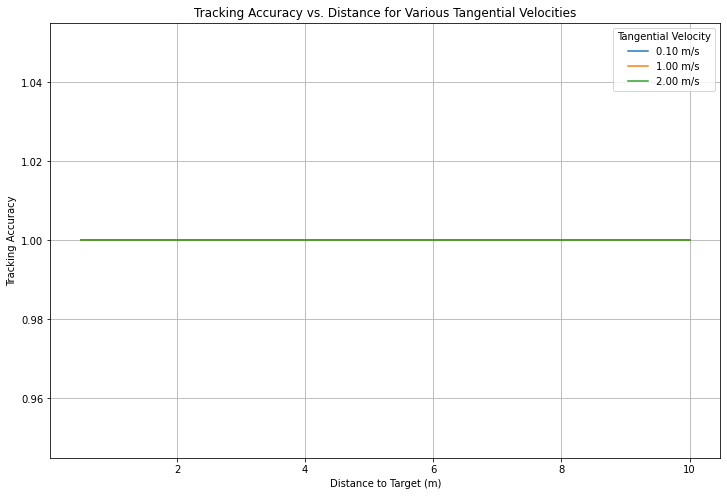

In [4]:
def phase_delay_to_time_delay(phase_delay, frequency):
    """Convert phase delay in degrees to time delay in seconds."""
    return phase_delay / 360 / frequency

def angular_velocity_required(distance, linear_velocity, conversion_factor):
    """Calculate the required angular velocity in degrees/s for tracking."""
    return linear_velocity / distance * conversion_factor

def calculate_accuracy(encoder_resolution, angular_velocity):
    """Estimate tracking accuracy based on encoder resolution and angular velocity."""
    # Simplified model: assume accuracy decreases as angular velocity approaches a threshold defined by the encoder resolution
    resolution_limit = encoder_resolution / 360  # Convert encoder resolution to degrees
    accuracy = 1 / (1 + angular_velocity / resolution_limit)
    return accuracy

def plot_accuracy_vs_distance(distances, frequencies, pan_phases, tilt_phases, linear_velocities, encoder_resolution, conversion_factor):
    """Plot tracking accuracy vs. distance for various tangential velocities."""
    plt.figure(figsize=(12, 8))

    for linear_velocity in linear_velocities:
        accuracies = []
        for distance in distances:
            # Calculate required angular velocity for the given distance and linear velocity
            angular_velocity = angular_velocity_required(distance, linear_velocity, conversion_factor)
            
            # Estimate tracking accuracy for both pan and tilt at the average phase delay
            average_phase_delay = np.mean([np.mean(pan_phases), np.mean(tilt_phases)])
            time_delay = phase_delay_to_time_delay(average_phase_delay, np.mean(frequencies))
            angular_velocity_with_delay = angular_velocity * time_delay  # Simplify to illustrate the effect
            
            accuracy = calculate_accuracy(encoder_resolution, angular_velocity_with_delay)
            accuracies.append(accuracy)
        
        plt.plot(distances, accuracies, label=f'{linear_velocity:.2f} m/s')

    plt.xlabel('Distance to Target (m)')
    plt.ylabel('Tracking Accuracy')
    plt.title('Tracking Accuracy vs. Distance for Various Tangential Velocities')
    plt.legend(title='Tangential Velocity')
    plt.grid(True)
    plt.show()

# Example usage
distances = np.linspace(0.5, 10, 100)  # Distance range in meters
frequencies = np.array([0.2, 10])  # Example frequency range for the test
pan_phases = np.array([10, -10])  # Example phase delays for pan
tilt_phases = np.array([10, -10])  # Example phase delays for tilt
linear_velocities = np.array([0.1, 1, 2])  # Example linear velocities in m/s
encoder_resolution = 4096  # Encoder resolution
conversion_factor = 90 / 2  # Conversion factor for degrees to meters based on FOV

plot_accuracy_vs_distance(distances, frequencies, pan_phases, tilt_phases, linear_velocities, encoder_resolution, conversion_factor)
